In [511]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
from math import sqrt, log, exp
from scipy.stats import norm
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Inputs
mu = np.array([
        [0.02], 
        [0.07], 
        [0.15], 
        [0.2],
    ])

sigma = np.array([
        [0.05], 
        [0.12], 
        [0.17], 
        [0.25],
    ])

rho = np.array([   
        [1, 0.3, 0.3, 0.3], 
        [0.3, 1, 0.6, 0.6], 
        [0.3, 0.6, 1, 0.6], 
        [0.3, 0.6, 0.6, 1]
    ])

In [3]:
#Scalars for analytical solutions
cov = np.diag(sigma.flatten()) @ rho @ np.diag(sigma.flatten())
I = np.ones(len(mu)).reshape(len(mu), 1)
inv_cov = np.linalg.inv(cov)
A = I.T @ inv_cov @ I
B = I.T @ inv_cov @ mu
C = mu.T @ inv_cov @ mu

In [78]:
#Simulations of unoptimal portfolios
numofportfolio = 700
np.random.seed()
simulation = 2 * np.random.random(size=(len(mu), numofportfolio)) - 1
simulation = simulation/simulation.sum(axis=0)
sim_vol = []
sim_ret = []
for i in range(simulation.shape[1]):
    weights = simulation[:,i].reshape(len(simulation[:,0]),1)
    sim_vol.append(sqrt(weights.T @ cov @ weights))
    sim_ret.append(float(weights.T @ mu))

In [76]:
#Analytical solution for efficient frontier given the absence of risk-free asset
target_rets = np.linspace(0, 1, 1000)
tvols = []
for tr in target_rets:
    ef_omega = (1 / (A * C - B ** 2)) * inv_cov @ ((A * mu - B * I) * tr + (C * I - B * mu))
    ef_vol = float(np.sqrt(ef_omega.T @ cov @ ef_omega))
    tvols.append(ef_vol)

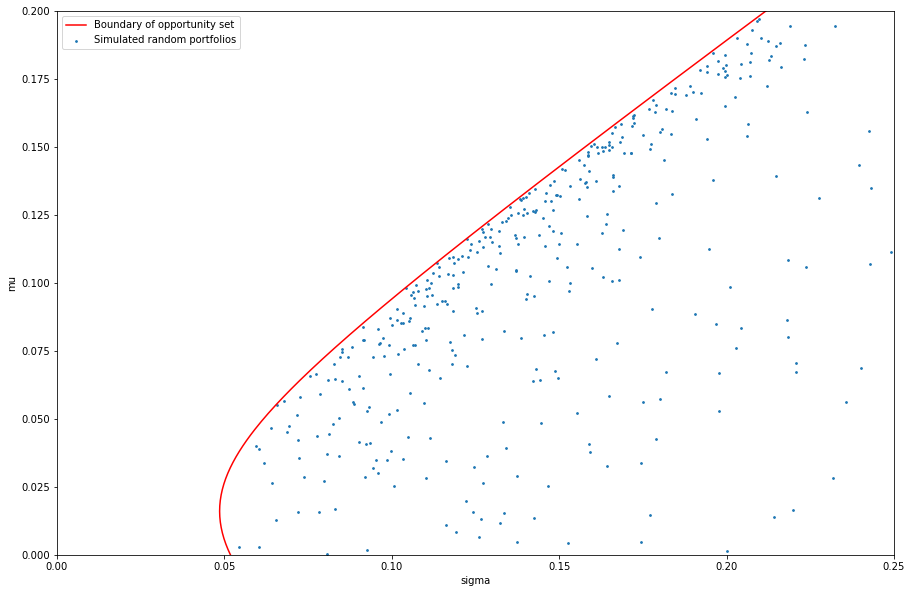

In [225]:
#Plot of simulated portfolios vs efficient frontier
plt.figure(figsize=(15, 10))
plt.xlabel('sigma')
plt.ylabel('mu')

plt.scatter(sim_vol, sim_ret, s=3, label='Simulated random portfolios')
plt.plot(tvols, target_rets, color='red', label='Boundary of opportunity set')

plt.xlim(0, 0.25)
plt.ylim(0, 0.2)
plt.legend(loc='upper left', frameon=True)
plt.show()

In [127]:
#Tangency portfolios calclations for various risk-free rates
tangency_table = pd.DataFrame(columns=['Risk-free rate', 'Mu', 'Sigma', 'Weights'])
for r in [0.005, 0.01, 0.015, 0.0175]:
    tangency_p = (1 / (B - A * r)) * inv_cov @ (mu - r * I)
    tangency_vol = float(np.sqrt(tangency_p.T @ cov @ tangency_p))
    tangency_mu = float(tangency_p.T @ mu)
    tangency_table = tangency_table.append({'Risk-free rate' : r, 'Mu' : tangency_mu, 'Sigma' : tangency_vol,
                                           'Weights' : tangency_p.flatten()}, ignore_index = True)
np.set_printoptions(precision=4)
tangency_table.style.format('{:.4f}', subset=['Mu', 'Sigma']).format('{:.2%}', subset=['Risk-free rate']).hide_index()

Risk-free rate,Mu,Sigma,Weights
0.50%,0.1861,0.1965,[ 0.0168 -0.2294 0.8143 0.3982]
1.00%,0.3261,0.3507,[-0.7459 -0.5106 1.4902 0.7663]
1.50%,1.7765,1.9724,[-8.6449 -3.4226 8.4897 4.5778]
1.75%,-1.2988,1.4735,[ 8.1035 2.7519 -6.3514 -3.5039]


In [114]:
r = 0.01
comp_vol_100 = []
comp_ret_100 = np.linspace(r, 1, 1000)
for m in comp_ret_100:
    omega_r = (m - r) * inv_cov @ (mu - r * I) / ((mu - r * I).T @ inv_cov @ (mu - r * I))
    vol_r = float(np.sqrt(omega_r.T @ cov @ omega_r))
    comp_vol_100.append(vol_r)

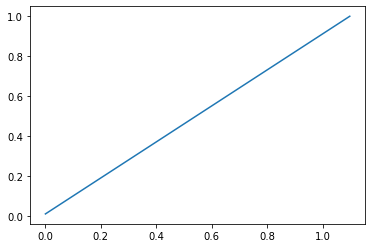

In [115]:
plt.plot(comp_vol_100, comp_ret_100)
plt.show()

In [116]:
r = 0.0175
comp_vol_175 = []
comp_ret_175 = np.linspace(r, 1, 1000)
for m in comp_ret_175:
    omega_r = (m - r) * inv_cov @ (mu - r * I) / ((mu - r * I).T @ inv_cov @ (mu - r * I))
    vol_r = float(np.sqrt(omega_r.T @ cov @ omega_r))
    comp_vol_175.append(vol_r)

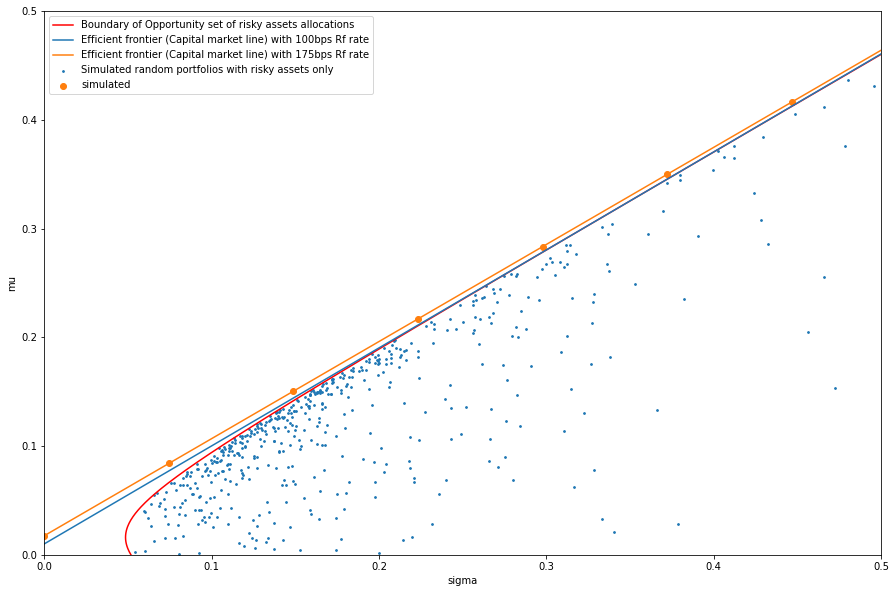

In [223]:
plt.figure(figsize=(15, 10))
plt.xlabel('sigma')
plt.ylabel('mu')

plt.scatter(sim_vol, sim_ret, s=3, label='Simulated random portfolios with risky assets only')
plt.plot(tvols, target_rets, color='red', label='Boundary of Opportunity set of risky assets allocations')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.plot(comp_vol_100, comp_ret_100, label='Efficient frontier (Capital market line) with 100bps Rf rate')
plt.plot(comp_vol_175, comp_ret_175, label='Efficient frontier (Capital market line) with 175bps Rf rate')
plt.scatter(vv, mm, label = 'simulated')
plt.legend(loc='upper left', frameon=True)
plt.show()

In [131]:
t = -tangency_p

In [136]:
m = float(t.T @ mu)

In [135]:
import scipy.optimize as sco

def portfolio_variance (w):
    return w.T @ cov @ w

def neg_sharpe_ratio(w):
    return (-1) * (w.T @ mu - r) / sqrt (portfolio_variance(w))

def neg_portfolio_return (w):
    return ((-1) * w.T @ mu)

In [149]:
cons = ({'type': 'eq', 'fun': lambda x: x.T @ mu - m + (1 - x.T @ I) * r})
bnds = tuple((-10, 10) for x in range(len(mu)))
initial_w = np.array(len(mu)*[1./len(mu)])

sco.minimize(portfolio_variance, initial_w, method='SLSQP', bounds=bnds, constraints=cons, tol=1e-15)

     fun: 2.1712462496296205
     jac: array([-0.0082, -0.1732, -0.4371, -0.6021])
 message: 'Optimization terminated successfully'
    nfev: 352
     nit: 42
    njev: 42
  status: 0
 success: True
       x: array([ 8.1035,  2.7519, -6.3514, -3.5039])

In [150]:
cons = ({'type': 'eq', 'fun': lambda x: x.T @ mu - m},
        {'type': 'eq', 'fun': lambda x: x.T @ I - 1})
bnds = tuple((-10, 10) for x in range(len(mu)))
initial_w = np.array(len(mu)*[1./len(mu)])

sco.minimize(portfolio_variance, initial_w, method='SLSQP', bounds=bnds, constraints=cons, tol=1e-15)

     fun: 2.1712462496296654
     jac: array([-0.0082, -0.1732, -0.4371, -0.6021])
 message: 'Iteration limit reached'
    nfev: 974
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([ 8.1035,  2.7519, -6.3514, -3.5039])

In [147]:
m = float((C - B * r) / (B - A * r))

In [208]:
mm = np.linspace(0, 1, 10)
vv = []
vr = []
for m in mm:
    ef_omega = (1 / (A * C - B ** 2)) * inv_cov @ ((A * mu - B * I) * m + (C * I - B * mu))
    ef_vol = float(np.sqrt(ef_omega.T @ cov @ ef_omega))
    vv.append(ef_vol)
    omega_r = (m - r) * inv_cov @ (mu - r * I) / ((mu - r * I).T @ inv_cov @ (mu - r * I))
    vol_r = float(np.sqrt(omega_r.T @ cov @ omega_r))
    vr.append(vol_r)

In [179]:
df = pd.DataFrame(data = [mm, vv, vr]).T

In [180]:
df.columns=['m', 'vv', 'vr']

In [181]:
(df['vv'] - df['vr']).min()

0.0032717944701559087

In [186]:
((df['m'] - r) / df['vv'])

0     -0.337755
1     -0.320780
2     -0.303424
3     -0.285697
4     -0.267615
         ...   
995    0.890644
996    0.890647
997    0.890650
998    0.890653
999    0.890656
Length: 1000, dtype: float64

In [185]:
(t.T @ mu  -  r) / np.sqrt(t.T @ cov @ t)

array([[0.8696]])

In [210]:
mm = np.linspace(0, 1, 10)
vv = []
for m in mm:
    cons = ({'type': 'eq', 'fun': lambda x: x.T @ mu - m + (1 - x.T @ I) * r})
    bnds = tuple((-10, 10) for x in range(len(mu)))
    initial_w = np.array(len(mu)*[1./len(mu)])

    opt_ef = sco.minimize(portfolio_variance, initial_w, method='SLSQP', bounds=bnds, constraints=cons, tol=1e-15)
    vv.append(sqrt(opt_ef['fun']))

In [214]:
tangency_p

array([[ 8.1035],
       [ 2.7519],
       [-6.3514],
       [-3.5039]])

In [220]:
weights_t = np.linspace(-5, 0, 100)
vv = []
mm = []
for t in weights_t:
    vol = abs(t) * sqrt(tangency_p.T @ cov @ tangency_p)
    ret = t * tangency_p.T @ mu + (1 - t) * r
    vv.append(vol)
    mm.append(float(ret))

In [480]:
def call_option_binomial(S, K, T, r, sigma, N):
    dt = T / N
    #Paul's parametrisation
    u = 1 + sigma * sqrt(dt)
    v = 1 - sigma * sqrt(dt)
    
    #Hull's parametrisation
    #u = exp(sigma * sqrt(dt))
    #v = exp(-sigma * sqrt(dt))
    
    p = (exp(r * dt) - v) / (u - v)
    d = exp(-r * dt)
    V = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        spot = S * (v ** i) * (u ** (N - i))
        V[i, N] = max(spot - K, 0)
    for j in range(N, 0, -1):
        for i in range(j):
            V[i, j - 1] = d * ( p * V[i, j] + (1 - p) * V[i + 1, j])
    return V[0, 0]

In [485]:
call_option_binomial(100, 100, 1, 0.1, 0.5, 2000)

23.928880934974632

In [262]:
binomial_option(100,100,0,0,1,2000, 2)[0][0]

19.74

In [470]:
def bsm_value(S, K, T, r, q, sigma, Flag):
    from math import log, sqrt, exp
    from scipy import stats

    S = float(S)
    K = float(K)
    d1 = (log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S/K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    if Flag == 0:
        value = (S * exp(-q * T) * stats.norm.cdf(d1, 0.0, 1.0) -
                 K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    elif Flag == 1:
        value = (K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) -
                 S * exp(-q * T) * stats.norm.cdf(-d1, 0.0, 1.0))
    else:
        value = 'NaN'
    return value

In [482]:
bsm_value(100, 100, 1, 0.1, 0, 0.5, 0)

23.926744828761358

In [236]:
def binomial_option(spot, strike, rate, sigma, time, steps, output=0):
    
    """
    binomial_option(spot, strike, rate, sigma, time, steps, output=0)
    
    Function to calculate binomial option pricing for european call option
    
    Params
    ------
    spot       -int or float    - spot price
    strike     -int or float    - strike price
    rate       -float           - interest rate
    time       -int or float    - expiration time
    steps      -int             - number of time steps
    output     -int             - [0: price, 1: payoff, 2: option value, 3: option delta]
    
    Returns
    --------
    out: ndarray
    An array object of price, payoff, option value and delta as specified by the output flag
    
    """
    
    # define parameters
    ts = time / steps
    u  = 1 + sigma*np.sqrt(ts) 
    v  = 1 - sigma*np.sqrt(ts)
    p  = 0.5 + rate *np.sqrt(ts) / (2*sigma)
    df = 1/(1+rate*ts)
    
    # initialize the arrays
    px = np.zeros((steps+1, steps+1))
    cp = np.zeros((steps+1, steps+1))
    V = np.zeros((steps+1, steps+1))
    d = np.zeros((steps+1, steps+1))
    
    # binomial loop : forward loop
    for j in range(steps+1):
        for i in range(j+1):
            px[i,j] = spot * np.power(v,i) * np.power(u,j-i)
            cp[i,j] = np.maximum(px[i,j] - strike, 0)
         
    # reverse loop
    for j in range(steps+1, 0, -1):
        for i in range(j):
            if (j==steps+1):
                V[i,j-1] = cp[i,j-1]
                d[i,j-1] = 0 
            else:
                V[i,j-1] = df*(p*V[i,j]+(1-p)*V[i+1,j])
                d[i,j-1] = (V[i,j]-V[i+1,j])/(px[i,j]-px[i+1,j])
    
    results = np.around(px,2), np.around(cp,2), np.around(V,2), np.around(d,4)

    return results[output]


In [300]:
vol_vector = np.linspace(0.05, 0.8, 16)
values_vector = []
for v in vol_vector:
    values_vector.append(call_option_binomial(100, 100, 1, 0.05, v, 10))

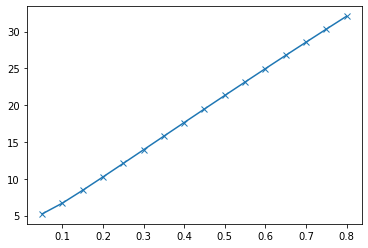

In [301]:
plt.plot(vol_vector, values_vector, 'x-')
plt.show()

In [294]:
NTS = range(4,51,1)
values_vector = []
for N in NTS:
    values_vector.append(call_option_binomial(100, 100, 1, 0.05, 0.2, N))

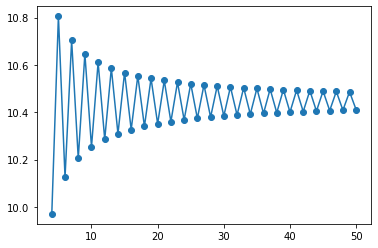

In [295]:
plt.plot(NTS, values_vector, 'o-')
plt.show()

In [504]:
filename = 'Data_SP500.csv'
input_data = pd.read_csv(filename, index_col=[0], parse_dates=True, dayfirst=True)
factor = norm.ppf(0.01)
calc_df = input_data.copy()
calc_df['Log Returns'] = np.log(calc_df['SP500']).diff()
calc_df['Rolling std dev'] = calc_df['Log Returns'].rolling(21).std()
calc_df['VaR'] = calc_df['Rolling std dev'] * factor * sqrt(10)
calc_df['Following 10D Return'] = np.log(calc_df['SP500'].shift(-11)) - np.log(calc_df['SP500'].shift(-1))
calc_df['VaR Breach'] = np.where(calc_df['Following 10D Return'] < calc_df['VaR'], 1, 0)
calc_df['VaR consecutive Breach'] = calc_df['VaR Breach'] * calc_df['VaR Breach'].shift(1)
print("Number of Breaches is", calc_df['VaR Breach'].sum())
print("Precentage of Breaches is", '{:.2%}'.format(calc_df['VaR Breach'].sum()/
                                                  len(calc_df[['VaR', 'Following 10D Return']].dropna())))
print("Number of Consecutive Breaches is", '{:.0f}'.format(calc_df['VaR consecutive Breach'].sum()))
print("Precentage of Consecutive Breaches is", 
      '{:.2%}'.format(calc_df['VaR consecutive Breach'].sum()/
                     (calc_df['VaR Breach'].sum() - 1)))

Number of Breaches is 25
Precentage of Breaches is 2.05%
Number of Consecutive Breaches is 14
Precentage of Consecutive Breaches is 58.33%


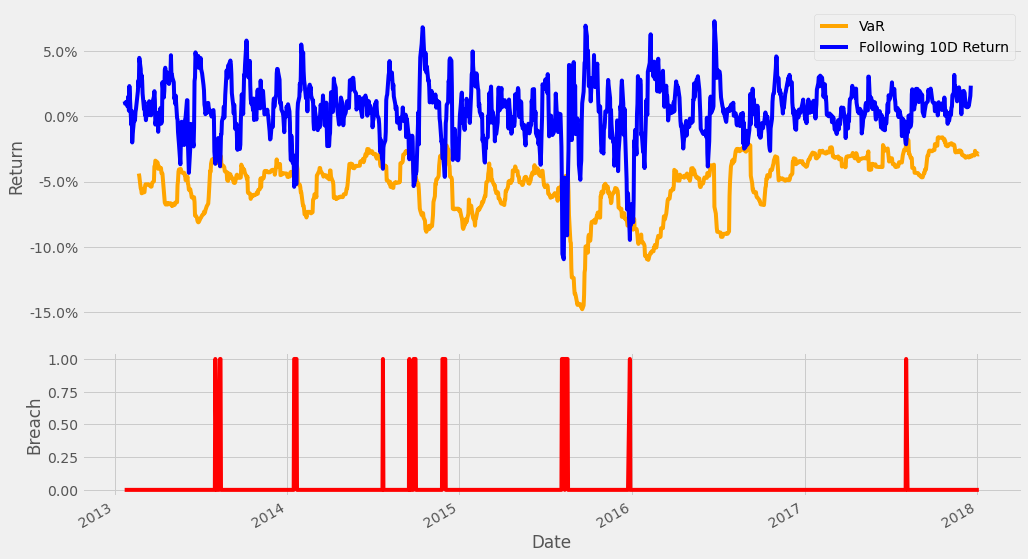

In [495]:
#plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (15,10))
gs = fig.add_gridspec(nrows=3, ncols=1)
ax = fig.add_subplot(gs[:-1])
ax2 = fig.add_subplot(gs[-1], sharex=ax)
ax.get_xaxis().set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.lineplot(data=calc_df.reset_index(), x="Date", y='VaR', ax=ax, color='orange')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='Following 10D Return', ax=ax, color='blue')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='VaR Breach', ax=ax2, color='red')
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax2.set_ylabel("Breach")
ax.legend(labels=['VaR', 'Following 10D Return', 'Breach'])
fig.autofmt_xdate()
plt.show()

In [412]:
llambda = 0.72
calc_df['Squared Log Returns'] = calc_df['Log Returns'] ** 2
calc_df['Rolling Variance'] = calc_df['Rolling std dev'] ** 2
calc_df['EWMA Variance'] = (1 - llambda) * calc_df['Squared Log Returns'] + \
llambda * calc_df['Rolling Variance'].shift(1)
calc_df['EWMA VaR'] = np.sqrt(calc_df['EWMA Variance']) * factor * sqrt(10)
calc_df['EWMA VaR Breach'] = np.where(calc_df['Following 10D Return'] < calc_df['EWMA VaR'], 1, 0)
calc_df['EWMA VaR consecutive Breach'] = calc_df['EWMA VaR Breach'] * calc_df['EWMA VaR Breach'].shift(1)
print("Number of Breaches is", calc_df['EWMA VaR Breach'].sum())
print("Precentage of Breaches is", '{:.2%}'.format(calc_df.dropna()['EWMA VaR Breach'].mean()))
print("Number of Consecutive Breaches is", '{:.0f}'.format(calc_df['EWMA VaR consecutive Breach'].sum()))
print("Precentage of Consecutive Breaches is", 
      '{:.2%}'.format(calc_df['EWMA VaR consecutive Breach'].sum()/
                     (calc_df['EWMA VaR Breach'].sum() - 1)))

Number of Breaches is 30
Precentage of Breaches is 2.46%
Number of Consecutive Breaches is 15
Precentage of Consecutive Breaches is 51.72%


In [468]:
llambda = 0.72
k = 21
calc_df['Squared Log Returns'] = calc_df['Log Returns'] ** 2
calc_df['EWMA Variance'] = np.nan
weights = llambda ** np.array(range(k))
for i in range(k-1, len(calc_df), 1):
    calc_df['EWMA Variance'].iloc[i] = (1 - llambda) * weights.dot(calc_df['Squared Log Returns'].iloc[i-k+1:i+1])
calc_df['EWMA VaR'] = np.sqrt(calc_df['EWMA Variance']) * factor * sqrt(10)
calc_df['EWMA VaR Breach'] = np.where(calc_df['Following 10D Return'] < calc_df['EWMA VaR'], 1, 0)
calc_df['EWMA VaR consecutive Breach'] = calc_df['EWMA VaR Breach'] * calc_df['EWMA VaR Breach'].shift(1)
print("Number of Breaches is", calc_df['EWMA VaR Breach'].sum())
print("Precentage of Breaches is", '{:.2%}'.format(calc_df.dropna()['EWMA VaR Breach'].mean()))
print("Number of Consecutive Breaches is", '{:.0f}'.format(calc_df['EWMA VaR consecutive Breach'].sum()))
print("Precentage of Consecutive Breaches is", 
      '{:.2%}'.format(calc_df['EWMA VaR consecutive Breach'].sum()/
                     (calc_df['EWMA VaR Breach'].sum() - 1)))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Number of Breaches is 35
Precentage of Breaches is 2.87%
Number of Consecutive Breaches is 20
Precentage of Consecutive Breaches is 58.82%


In [515]:
llambda = 0.72
calc_df['Squared Log Returns'] = calc_df['Log Returns'] ** 2
calc_df['EWMA Variance'] = np.nan
calc_df['EWMA Variance'] = calc_df['Log Returns'].std() ** 2
for i in range(1, len(calc_df), 1):
        calc_df['EWMA Variance'].iloc[i] = \
        llambda * calc_df['EWMA Variance'].iloc[i-1] + (1 - llambda) * calc_df['Squared Log Returns'].iloc[i]
#calc_df['EWMA Variance'] = llambda * calc_df['EWMA Variance'].shift(1) + (1 - llambda) * calc_df['Squared Log Returns']
calc_df['EWMA VaR'] = np.sqrt(calc_df['EWMA Variance']) * factor * sqrt(10)
calc_df['EWMA VaR Breach'] = np.where(calc_df['Following 10D Return'] < calc_df['EWMA VaR'], 1, 0)
calc_df['EWMA VaR consecutive Breach'] = calc_df['EWMA VaR Breach'] * calc_df['EWMA VaR Breach'].shift(1)
print("Number of Breaches is", calc_df['EWMA VaR Breach'].sum())
print("Precentage of Breaches is", '{:.2%}'.format(calc_df['EWMA VaR Breach'].sum()/
                                                   len(calc_df[['VaR', 'Following 10D Return']].dropna())))
print("Number of Consecutive Breaches is", '{:.0f}'.format(calc_df['EWMA VaR consecutive Breach'].sum()))
print("Precentage of Consecutive Breaches is", 
      '{:.2%}'.format(calc_df['EWMA VaR consecutive Breach'].sum()/
                     (calc_df['EWMA VaR Breach'].sum() - 1)))

Number of Breaches is 32
Precentage of Breaches is 2.63%
Number of Consecutive Breaches is 17
Precentage of Consecutive Breaches is 54.84%


In [414]:
llambda ** np.array(range(22))

array([1.    , 0.72  , 0.5184, 0.3732, 0.2687, 0.1935, 0.1393, 0.1003,
       0.0722, 0.052 , 0.0374, 0.027 , 0.0194, 0.014 , 0.0101, 0.0072,
       0.0052, 0.0038, 0.0027, 0.0019, 0.0014, 0.001 ])

In [513]:
calc_df.head(30)

,SP500,Log Returns,Rolling std dev,VaR,Following 10D Return,VaR Breach,VaR consecutive Breach,Squared Log Returns,EWMA Variance,EWMA VaR,EWMA VaR Breach,EWMA VaR consecutive Breach
Date,,,,,,,,,,,,
2013-01-22,1492.560059,NaN,NaN,NaN,0.011513,0,NaN,NaN,0.000056,-0.055164,0,NaN
2013-01-23,1494.810059,0.001506,NaN,NaN,0.009700,0,0.0,2.269066e-06,0.000041,-0.047174,0,0.0
2013-01-24,1494.819946,0.000007,NaN,NaN,0.009911,0,0.0,4.374759e-11,0.000030,-0.040029,0,0.0
2013-01-25,1502.959961,0.005431,NaN,NaN,0.011156,0,0.0,2.949260e-05,0.000030,-0.040007,0,0.0
2013-01-28,1500.180054,-0.001851,NaN,NaN,0.007657,0,0.0,3.427438e-06,0.000022,-0.034704,0,0.0
2013-01-29,1507.839966,0.005093,NaN,NaN,0.012156,0,0.0,2.593869e-05,0.000023,-0.035499,0,0.0
2013-01-30,1501.959961,-0.003907,NaN,NaN,0.015414,0,0.0,1.526656e-05,0.000021,-0.033744,0,0.0
2013-01-31,1498.109985,-0.002567,NaN,NaN,0.004365,0,0.0,6.587396e-06,0.000017,-0.030326,0,0.0
2013-02-01,1513.170044,0.010003,NaN,NaN,0.023281,0,0.0,1.000503e-04,0.000040,-0.046672,0,0.0


In [467]:
calc_df.tail(30)

,SP500,Log Returns,Rolling std dev,VaR,Following 10D Return,VaR Breach,VaR consecutive Breach,Squared Log Returns,Rolling Variance,EWMA Variance,EWMA VaR,EWMA VaR Breach,EWMA VaR consecutive Breach
Date,,,,,,,,,,,,,
2017-11-22,2597.080078,-0.000751,0.003740,-0.027515,0.015247,0,0.0,5.633143e-07,0.000014,0.000041,-0.030990,0,0.0
2017-11-24,2602.419922,0.002054,0.003557,-0.026168,0.018684,0,0.0,4.218852e-06,0.000013,0.000042,-0.029567,0,0.0
2017-11-27,2601.419922,-0.000384,0.003565,-0.026229,0.022265,0,0.0,1.477108e-07,0.000013,0.000041,-0.034354,0,0.0
2017-11-28,2627.040039,0.009800,0.003760,-0.027664,0.014012,0,0.0,9.604651e-05,0.000014,0.000067,-0.016750,0,0.0
2017-11-29,2626.070068,-0.000369,0.003658,-0.026909,0.013909,0,0.0,1.363781e-07,0.000013,0.000041,-0.013209,0,0.0
2017-11-30,2647.580078,0.008158,0.003979,-0.029274,0.001672,0,0.0,6.654622e-05,0.000016,0.000059,-0.014999,0,0.0
2017-12-01,2642.219971,-0.002027,0.004045,-0.029755,0.012633,0,0.0,4.107038e-06,0.000016,0.000042,-0.016102,0,0.0
2017-12-04,2639.439941,-0.001053,0.004068,-0.029930,0.019034,0,0.0,1.108200e-06,0.000017,0.000041,-0.018957,0,0.0
2017-12-05,2629.570068,-0.003746,0.004172,-0.030694,0.019545,0,0.0,1.403544e-05,0.000017,0.000044,-0.017268,0,0.0


In [447]:
calc_df['EWMA Variance'].tail(30)

Date
2013-01-22         NaN
2013-01-23         NaN
2013-01-24         NaN
2013-01-25         NaN
2013-01-28         NaN
2013-01-29         NaN
2013-01-30         NaN
2013-01-31         NaN
2013-02-01         NaN
2013-02-04         NaN
2013-02-05         NaN
2013-02-06         NaN
2013-02-07         NaN
2013-02-08         NaN
2013-02-11         NaN
2013-02-12         NaN
2013-02-13         NaN
2013-02-14         NaN
2013-02-15         NaN
2013-02-19         NaN
2013-02-20         NaN
2013-02-21    0.000016
2013-02-22    0.000021
2013-02-25    0.000029
2013-02-26    0.000029
2013-02-27    0.000039
2013-02-28    0.000045
2013-03-01    0.000056
2013-03-04    0.000075
2013-03-05    0.000066
Name: EWMA Variance, dtype: float64

In [422]:
np.array(range(k, len(calc_df), 1))

array([  21,   22,   23, ..., 1247, 1248, 1249])

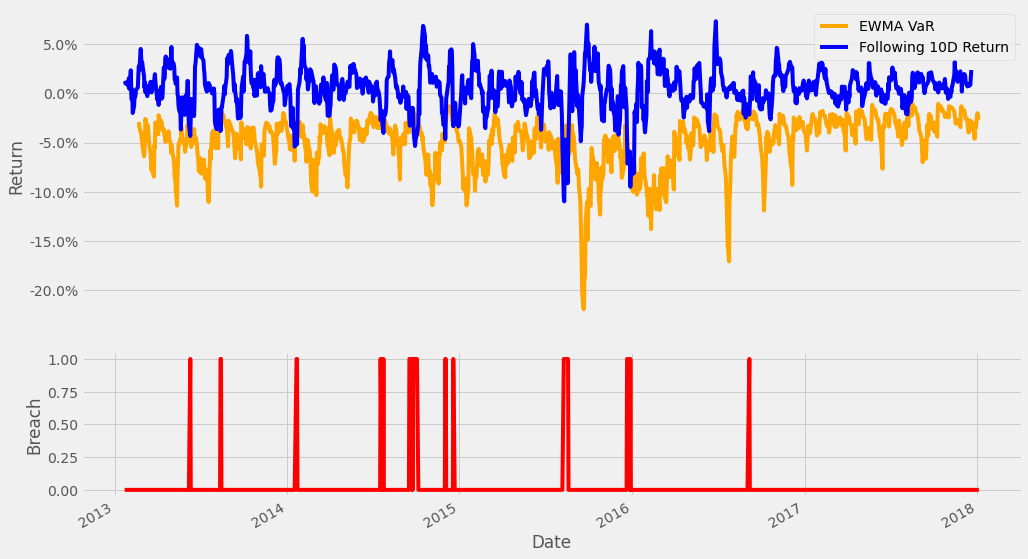

In [466]:
fig = plt.figure(figsize = (15,10))
gs = fig.add_gridspec(nrows=3, ncols=1)
ax = fig.add_subplot(gs[:-1])
ax2 = fig.add_subplot(gs[-1], sharex=ax)
ax.get_xaxis().set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.lineplot(data=calc_df.reset_index(), x="Date", y='EWMA VaR', ax=ax, color='orange')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='Following 10D Return', ax=ax, color='blue')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='EWMA VaR Breach', ax=ax2, color='red')
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax2.set_ylabel("Breach")
ax.legend(labels=['EWMA VaR', 'Following 10D Return', 'Breach'])
fig.autofmt_xdate()
plt.show()

In [502]:
len(calc_df[['VaR', 'Following 10D Return']].dropna())

1218

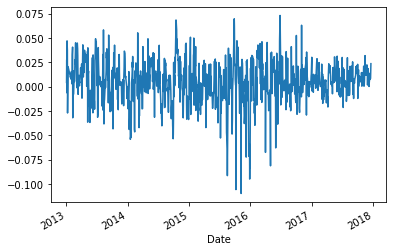

In [337]:
calc_df['Following 10D Return'].plot()

In [388]:
calc_df['EWMA VaR Breach'].sum()

30

In [340]:
calc_df['VaR consecutive Breach'].sum()

14.0

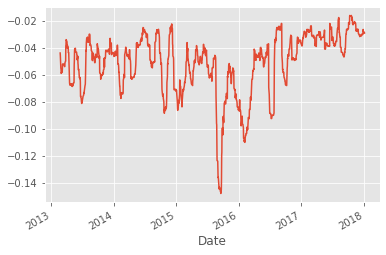

In [361]:
calc_df['VaR'].sort_index().plot()

In [350]:
calc_df.reset_index()['Date']

0      2013-01-22
1      2013-01-23
2      2013-01-24
3      2013-01-25
4      2013-01-28
          ...    
1245   2017-12-29
1246   2018-02-01
1247   2018-03-01
1248   2018-04-01
1249   2018-05-01
Name: Date, Length: 1250, dtype: datetime64[ns]

In [475]:
def expected_shortfall_sn(x):
    return -norm.pdf(norm.ppf(x))/x

In [478]:
percentiles = np.array([99.95, 99.75, 99.5, 99.25, 99, 98.5, 98, 97.5])
for p in percentiles:
    x = 1 - p / 100
    print(p, expected_shortfall_sn(x))

99.95 -3.5543806938542857
99.75 -3.104357363203606
99.5 -2.8919486053834813
99.25 -2.761239803172472
99.0 -2.665214220345806
98.5 -2.5246953986002407
98.0 -2.4209067940371014
97.5 -2.3378027922014133


In [493]:
input_data

,SP500
Date,
2013-01-22,1492.560059
2013-01-23,1494.810059
2013-01-24,1494.819946
2013-01-25,1502.959961
2013-01-28,1500.180054
...,...
2017-12-29,2673.610107
2018-01-02,2695.810059
2018-01-03,2713.060059
